# Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.



### Importing general dependencies

In [1]:
#Import general dependencies

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Input, Add, Flatten, Dropout, MaxPool2D, MaxPooling2D
from keras.initializers import glorot_uniform as gu
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


!git clone https://github.com/sofzcc/project-1-deep-learning-image-classification-with-cnn/


Cloning into 'project-1-deep-learning-image-classification-with-cnn'...
remote: Enumerating objects: 26271, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 26271 (delta 22), reused 3 (delta 0), pack-reused 26199
Receiving objects: 100% (26271/26271), 590.76 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (24/24), done.


### Data Loading


In [2]:
!kaggle datasets download -d alessiocorrado99/animals10 -p /content

# Define the path to the zip file
zip_file_path = '/content/animals10.zip'

# Define the directory where you want to extract the files
extract_dir = '/content/animals10/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 583M/586M [00:29<00:00, 22.9MB/s]
100% 586M/586M [00:29<00:00, 20.8MB/s]


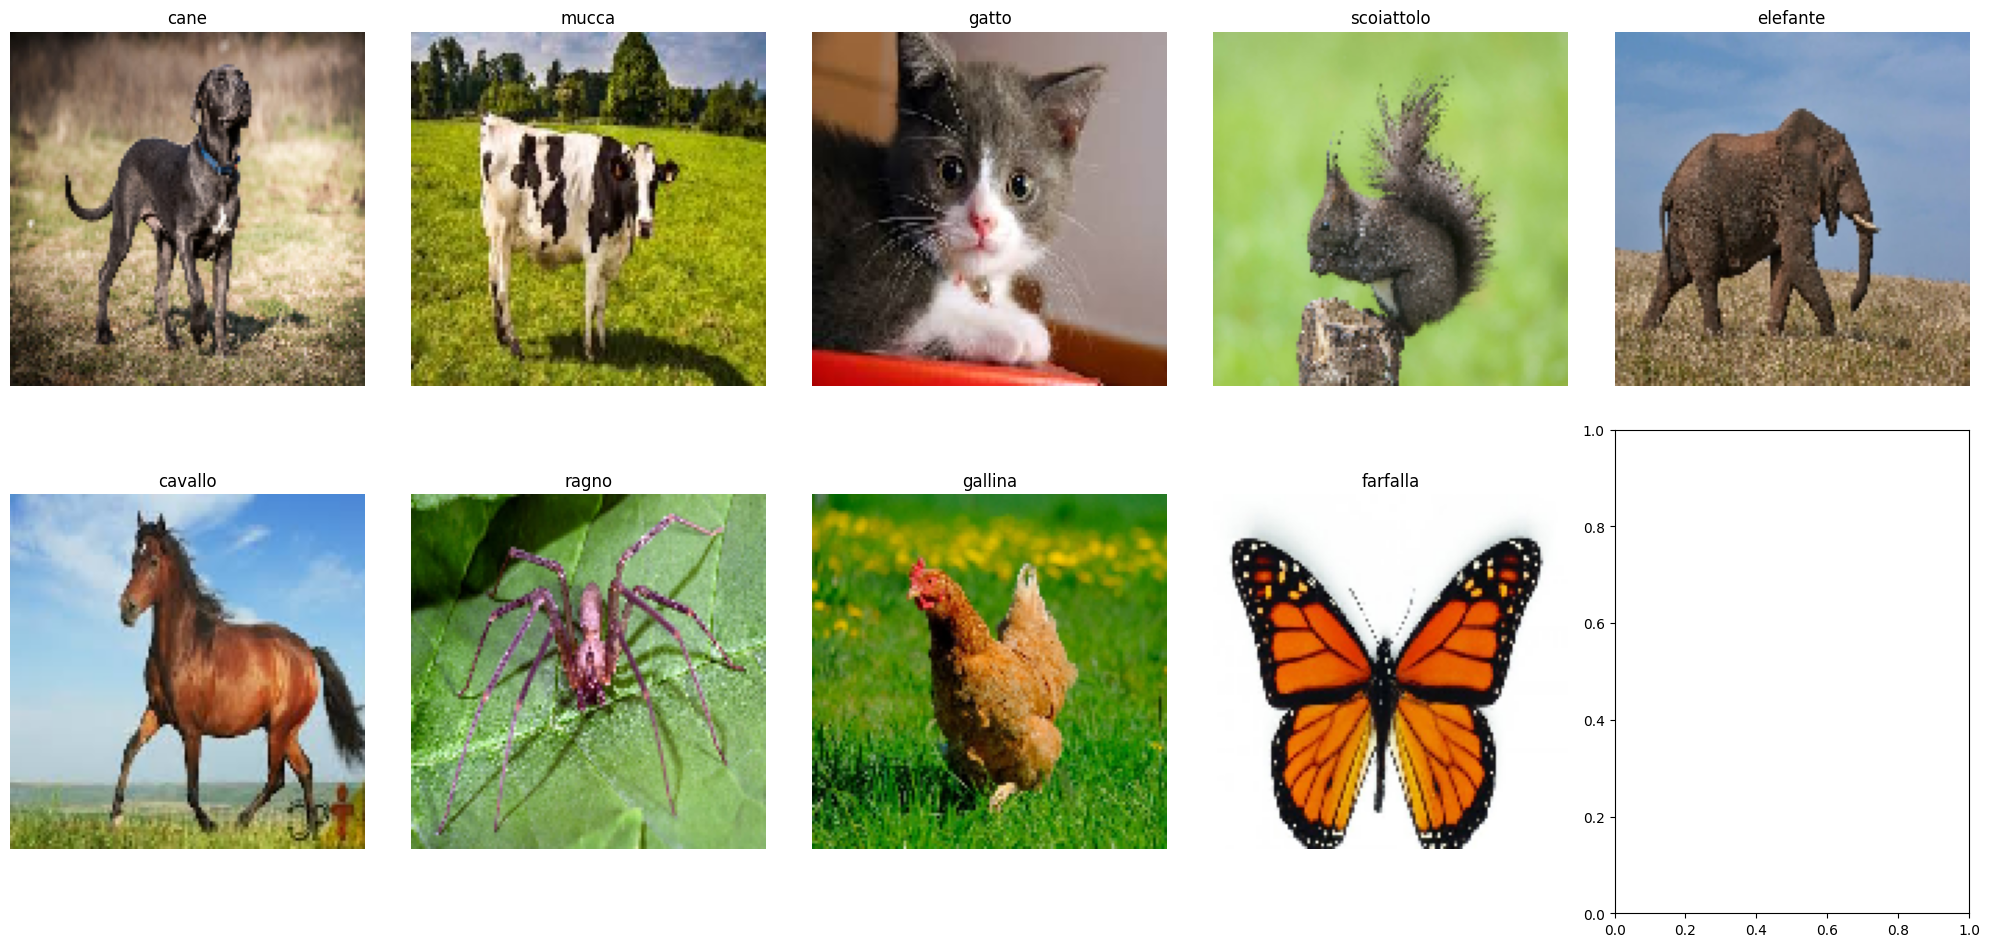

In [3]:

#Load into a dataset

animals_dir = '/content/animals10/raw-img'

#Create test dataset
test_folder_path = '/content/project-1-deep-learning-image-classification-with-cnn/test'

test_images = []
test_class_names = []

for folder in os.listdir(test_folder_path):
    folder_path = os.path.join(test_folder_path, folder)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path)
                test_images.append(np.array(img))
                test_class_names.append(folder)

#Plotting the images from each class in the test set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()
for ax, class_name in zip(axes, test_class_names):
    class_dir = os.path.join(test_folder_path, class_name)
    file_list = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    if file_list:
      path_sample = os.path.join(class_dir, file_list[0])  # Selecting the first file
      img = image.load_img(path_sample, target_size=(128, 128))
      ax.imshow(img)
      ax.set_title(class_name)
      ax.axis('off')
    else:
      print(f"Class {class_name} has no valid images.")
      continue
plt.tight_layout()
plt.show()

#Data Exploration

Explore the Dataset: Get an overview of the data, including the number of classes, number of images per class, and sample images.


In [4]:
# List all classes
print("This dataset contains the following classes:")
class_names = []
for class_name in os.listdir(animals_dir):
    class_names.append(class_name)
    print(f"{class_name}")

# Counting total images per class
image_class = {}
for class_name in class_names:
    class_dir = os.path.join(animals_dir, class_name)
    image_class[class_name] = len(os.listdir(class_dir))

print("\n\nTotal images per class:")
for class_name, count in image_class.items():
    print(f"{class_name} : {count}")

This dataset contains the following classes:
cane
mucca
gatto
scoiattolo
elefante
cavallo
ragno
gallina
pecora
farfalla


Total images per class:
cane : 4863
mucca : 1866
gatto : 1668
scoiattolo : 1862
elefante : 1446
cavallo : 2623
ragno : 4821
gallina : 3098
pecora : 1820
farfalla : 2112


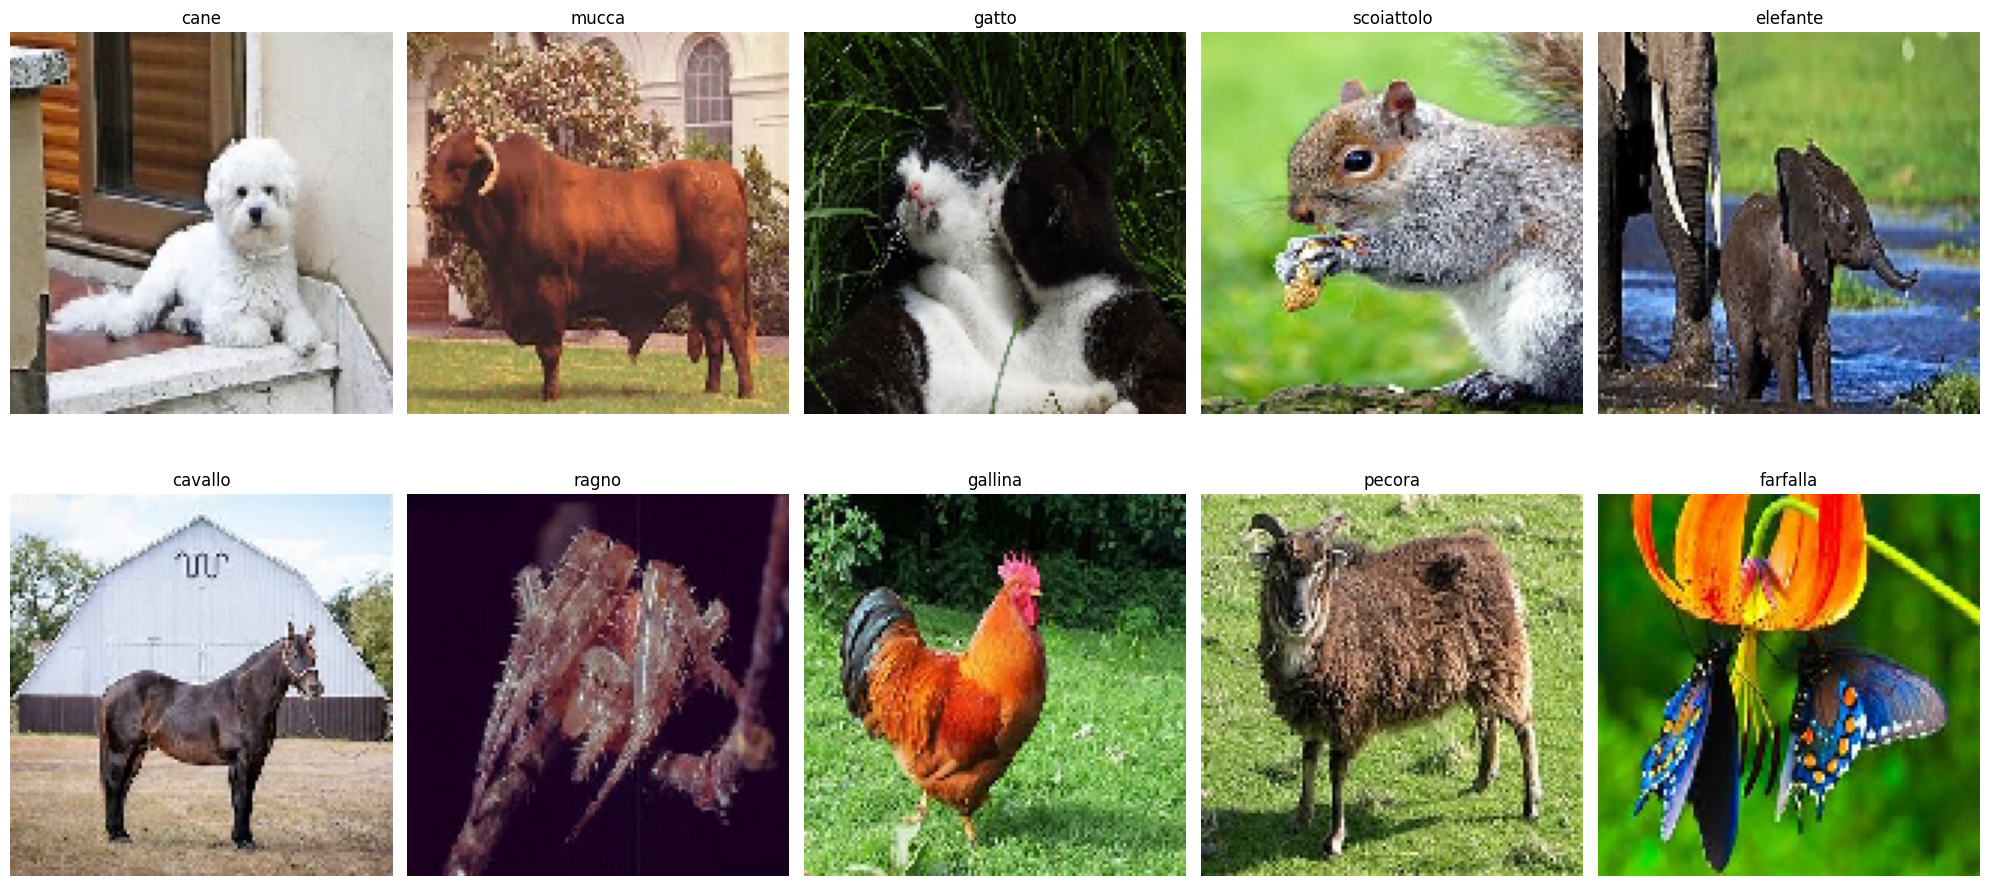

In [5]:
#Plotting sample images from each class

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()
for ax, class_name in zip(axes, class_names):
    class_dir = os.path.join(animals_dir, class_name)
    file_list = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    if file_list:
      path_sample = os.path.join(class_dir, file_list[0])  # Selecting the first file
      img = image.load_img(path_sample, target_size=(128, 128))
      ax.imshow(img)
      ax.set_title(class_name)
      ax.axis('off')
    else:
      continue
plt.tight_layout()
plt.show()

### Data Preprocessing

Preprocessing (e.g., normalization, resizing, augmentation).
Create visualizations of some images, and labels.


In [6]:


data_generator = ImageDataGenerator(
    rescale=1./255.0, #normalizes pixel values from 0-255 to 0-1
    horizontal_flip=True, #randomly flips images horizontally
    zoom_range=0.2,         # Zoom in on the image by a maximum of 20%
    width_shift_range=0.2,  # Shift the image horizontally by a maximum of 20% of the width
    height_shift_range=0.2, # Shift the image vertically by a maximum of 20% of the height
    shear_range=0.2,        # Shear the image by a maximum of 20%
    brightness_range=[0.5, 1.5],
    validation_split=0.2,
    fill_mode="nearest") #splits the data into train and validation sets



#Split into train and test sets

train_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(128,128),
    batch_size = 64,
    class_mode="sparse",
    subset="training"
)

validation_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(128,128),
    batch_size = 64,
    class_mode="sparse",
    subset="validation"
)
test_data_generator = ImageDataGenerator(rescale= 1./255.0)
test_set = test_data_generator.flow_from_directory(
    test_folder_path,
    target_size=(128,128),
    batch_size = 64,
    class_mode='sparse'
)



Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Found 9 images belonging to 10 classes.


## Model Architecture

Design a CNN architecture suitable for image classification.
Include convolutional layers, pooling layers, and fully connected layers.


In [10]:


#MReLU is an element wise operation (applied per pixel) and replaces all negative pixel values in the feature map by zero
#and to introduce non-linearity to the network
#Other non linear functions such as tanh or sigmoid can also be
#used instead of ReLU, but ReLU has been found to perform better in most situations

cnn_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),

    #Conv2D(64, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(),
    #MaxPooling2D((2, 2), strides=2),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(class_names), activation="softmax"),
]
)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)



In [11]:
print(len(train_set))

cnn_model.summary()


328
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                  

##Model Training

Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
Utilize techniques such as early stopping to prevent overfitting.


In [12]:
history = cnn_model.fit(train_set, validation_data=validation_set, epochs=30, callbacks=[early_stopping, reduce_lr], verbose=2)

Epoch 1/30
328/328 - 140s - loss: 2.6328 - accuracy: 0.2581 - val_loss: 3.1484 - val_accuracy: 0.2232 - lr: 1.0000e-04 - 140s/epoch - 426ms/step
Epoch 2/30
328/328 - 136s - loss: 2.1654 - accuracy: 0.3214 - val_loss: 1.8865 - val_accuracy: 0.3704 - lr: 1.0000e-04 - 136s/epoch - 416ms/step
Epoch 3/30
328/328 - 136s - loss: 1.9480 - accuracy: 0.3610 - val_loss: 1.6904 - val_accuracy: 0.4427 - lr: 1.0000e-04 - 136s/epoch - 413ms/step
Epoch 4/30
328/328 - 136s - loss: 1.8306 - accuracy: 0.3960 - val_loss: 1.5576 - val_accuracy: 0.4568 - lr: 1.0000e-04 - 136s/epoch - 414ms/step
Epoch 5/30
328/328 - 135s - loss: 1.7399 - accuracy: 0.4199 - val_loss: 1.5152 - val_accuracy: 0.4765 - lr: 1.0000e-04 - 135s/epoch - 412ms/step
Epoch 6/30
328/328 - 137s - loss: 1.6647 - accuracy: 0.4402 - val_loss: 1.4181 - val_accuracy: 0.5080 - lr: 1.0000e-04 - 137s/epoch - 417ms/step
Epoch 7/30
328/328 - 136s - loss: 1.6154 - accuracy: 0.4572 - val_loss: 1.4302 - val_accuracy: 0.5090 - lr: 1.0000e-04 - 136s/epoc

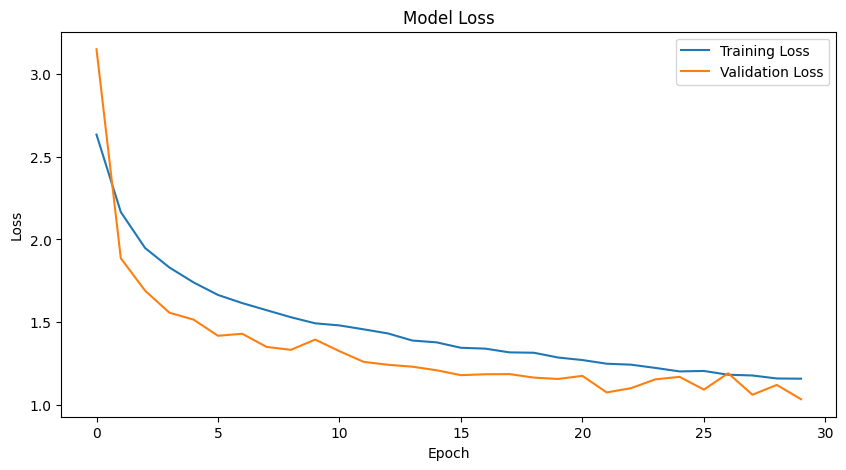

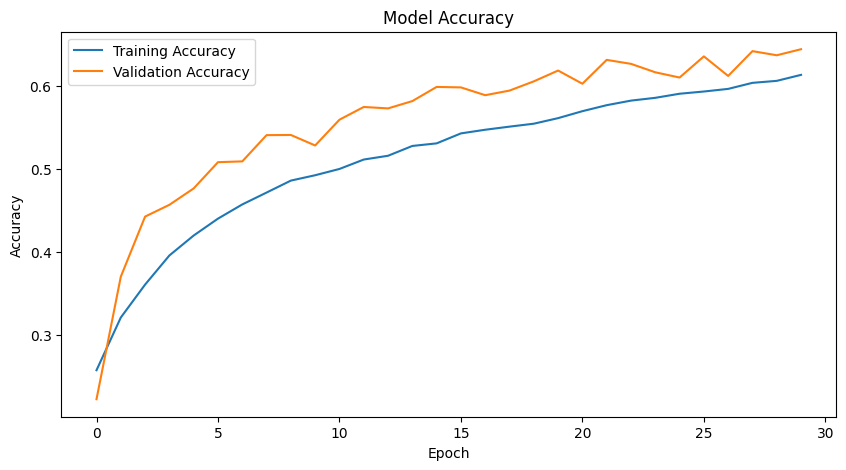

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model Evaluation

Evaluate the trained model on a separate validation set.
Compute and report metrics such as accuracy, precision, recall, and F1-score.
Visualize the confusion matrix to understand model performance across different classes

# Separate validation set

In [14]:
test_loss, test_acc = cnn_model.evaluate(validation_set)
print(f"Test accuracy: {test_acc}")

82/82 [==============================] - 27s 334ms/step - loss: 1.0330 - accuracy: 0.6535
Test accuracy: 0.6534786224365234


In [15]:
test_loss, test_acc = cnn_model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

1/1 [==============================] - 0s 249ms/step - loss: 0.5751 - accuracy: 0.8889
Test accuracy: 0.8888888955116272


### Compute and report metrics such as accuracy, precision, recall, and F1-score

In [16]:
from sklearn.metrics import classification_report

validation_pred = cnn_model.predict(validation_set)
validation_pred_labels = np.argmax(validation_pred, axis=1)

print(f"Classification report:")
print(classification_report(validation_set.classes, validation_pred_labels, target_names=class_names))
print(validation_pred_labels)

82/82 [==============================] - 27s 331ms/step
Classification report:
              precision    recall  f1-score   support

        cane       0.19      0.25      0.22       972
       mucca       0.10      0.13      0.12       524
       gatto       0.06      0.06      0.06       289
  scoiattolo       0.10      0.10      0.10       422
    elefante       0.11      0.12      0.12       619
     cavallo       0.06      0.03      0.04       333
       ragno       0.05      0.03      0.04       373
     gallina       0.07      0.05      0.06       364
      pecora       0.18      0.19      0.19       964
    farfalla       0.07      0.06      0.06       372

    accuracy                           0.13      5232
   macro avg       0.10      0.10      0.10      5232
weighted avg       0.12      0.13      0.13      5232

[9 5 1 ... 4 0 4]


# Compute the confusion matrix

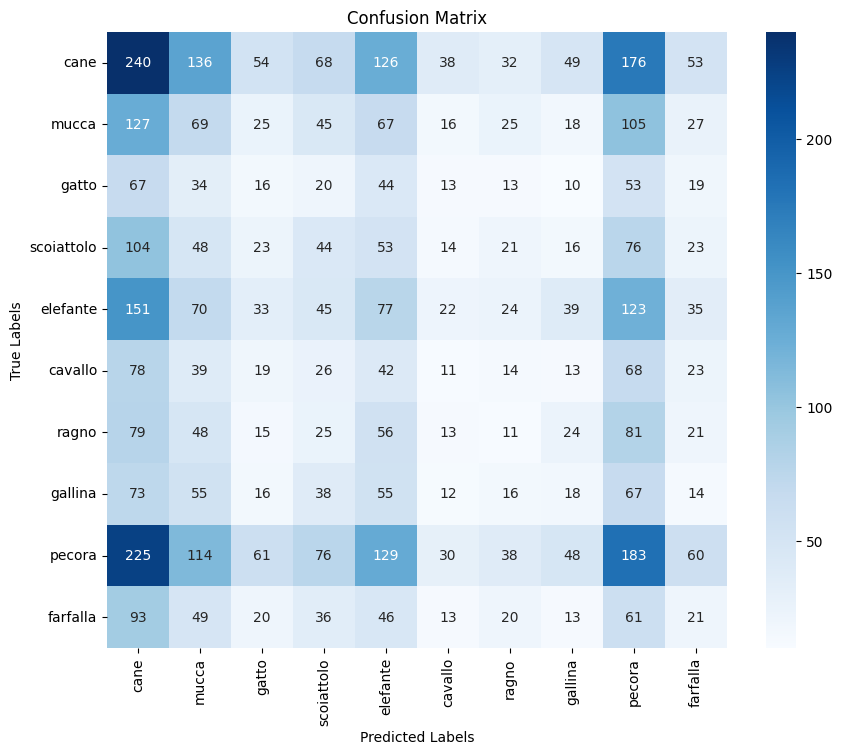

## Transfer Learning

Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

### Removing the first layer and performing transfer learning using pre-trained models

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

#Load the VGG16 pre-trained model with imagenet weights without the top layer
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))


#Freeze the VGG_model layers
for layer in VGG_model.layers:
  layer.trainable = False

#Add custom classification layers
x = Flatten()(VGG_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

#Create the model
transfer_model = Model(inputs=VGG_model.input, outputs=output)

#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
transfer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = transfer_model.fit(
    train_set,
    validation_data=validation_set,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the model
test_loss, test_acc = transfer_model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

### Removing the first layer and performing transfer learning using pre-trained models

In [ ]:
# Save the model to disk

model_dir = "./model"
model_version = 1
model_export_path = f"{model_dir}/{model_version}"

tf.saved_model.save(
    model,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")